In [ ]:
!for d in /content/drive/MyDrive/AptosData/aptos-augmented-images/*/ ; do echo "$(basename "$d"): $(find "$d" -type f | wc -l)"; done


0: 2000
1: 2000
2: 2000
3: 2000
4: 2000
aptos-augmented-images: 1253


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=c993183895f13bfeabcf29f6716a0f05718c72e1d7d13502e536ca60291f8431
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet-pytorch
Using device: cuda
GPU: Tesla T4
Creating stratified train/validation split...
Class 0: 2000 images
Class 1: 2000 images
Class 2: 2000 images
Class 3: 2000 images
Class 4: 2000 images
Total images: 10000

Training distribution:
  Class 0: 1800 samples
  Class 1: 1800 samples
  Class 2: 1800 samples
  Class 3: 1800 samples
  Class 4: 1800 samples

Validation distribution:
  Class 0: 200 samples
  Class 1: 200 samples
  Class 2: 200 samples
  Class 3: 200 samples
  Class 4: 200 samples
Creating dataset

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Total parameters: 11,617,325
Trainable parameters: 11,617,325
🚀 Starting improved training...

Epoch 1/60
Batch 0/563, Loss: 2.3154, LR: 0.001000
Batch 100/563, Loss: 1.3067, LR: 0.000501
Batch 200/563, Loss: 1.4318, LR: 0.000692
Batch 300/563, Loss: 0.9187, LR: 0.001000
Batch 400/563, Loss: 1.7595, LR: 0.000778
Batch 500/563, Loss: 0.8496, LR: 0.000309
Train Loss: 1.1540, Train Acc: 0.5210
Val Loss: 0.8108, Val Acc: 0.6750
Learning Rate: 0.000080
🎯 New best model saved! Validation accuracy: 0.6750 (67.50%)

Epoch 2/60
Batch 0/563, Loss: 1.0660, LR: 0.000080
Batch 100/563, Loss: 1.2555, LR: 0.000989
Batch 200/563, Loss: 0.6646, LR: 0.000883
Batch 300/563, Loss: 0.8178, LR: 0.000687
Batch 400/563, Loss: 0.8492, LR: 0.000447
Batch 500/563, Loss: 0.6336, LR: 0.000219
Train Loss: 0.9438, Train Acc: 0.6197
Val Loss: 0.6858, Val Acc: 0.7310
Learning Rate: 0.000108
🎯 New best model saved! Validation accuracy: 0.7310 (73.10%)

Epoch 3/60
Batch 0/563, Loss: 1.0516, LR: 0.000108
Batch 100/563, L

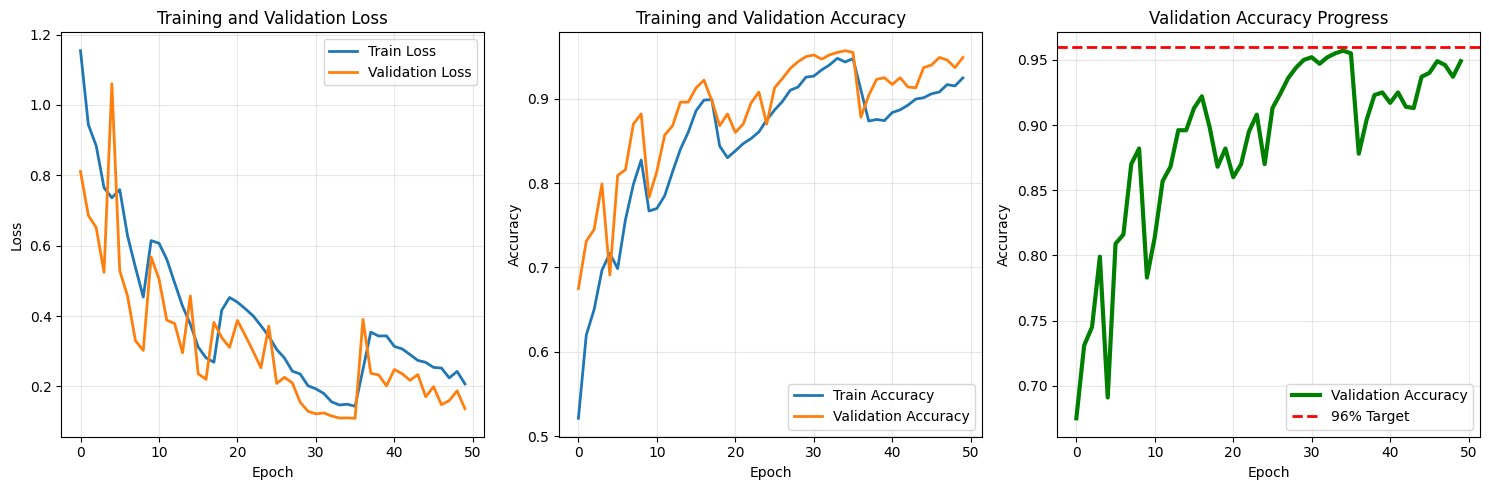


📊 Loading best model for final evaluation...

🎯 FINAL RESULTS:
Final Validation Accuracy with TTA: 0.9570 (95.70%)
Target Achievement: ❌ FAILED

📋 Classification Report:
                  precision    recall  f1-score   support

           No DR     0.9706    0.9900    0.9802       200
            Mild     0.9409    0.9550    0.9479       200
        Moderate     0.9303    0.9350    0.9327       200
          Severe     0.9598    0.9550    0.9574       200
Proliferative DR     0.9845    0.9500    0.9669       200

        accuracy                         0.9570      1000
       macro avg     0.9572    0.9570    0.9570      1000
    weighted avg     0.9572    0.9570    0.9570      1000



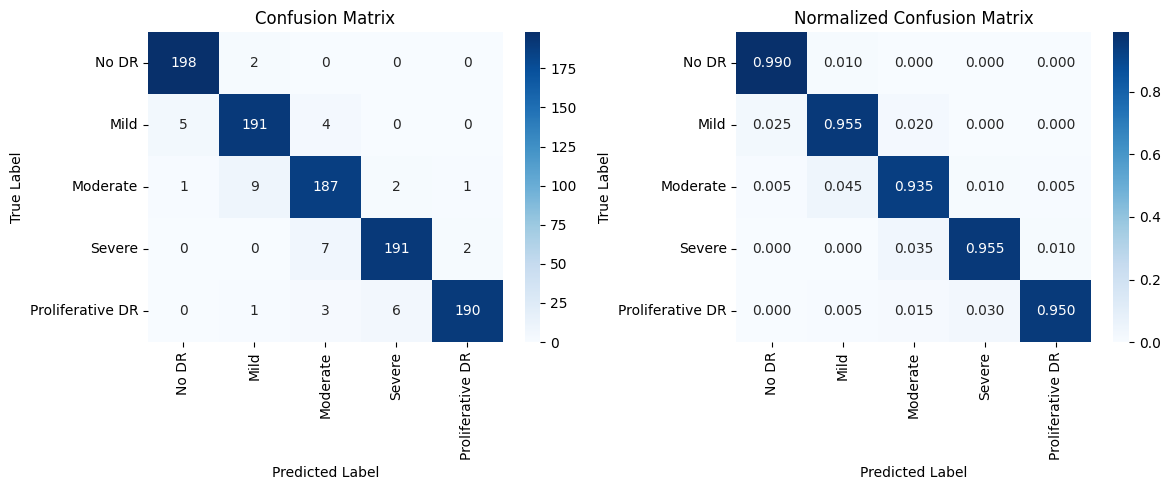


📊 Per-Class Accuracy:
No DR               : 0.9900 (99.00%)
Mild                : 0.9550 (95.50%)
Moderate            : 0.9350 (93.50%)
Severe              : 0.9550 (95.50%)
Proliferative DR    : 0.9500 (95.00%)

🎯 PERFORMANCE SUMMARY:
📊 Achieved: 95.70%
🎯 Target: 96.00%
💾 Final model saved
🚀 Training completed!


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install efficientnet-pytorch
!pip install albumentations
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from PIL import Image
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import warnings
import random
import shutil
from collections import Counter
import torch.nn.functional as F
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

# Dataset path
dataset_path = '/content/drive/MyDrive/AptosData/aptos-augmented-images'

# Improved function to create stratified train/val split
def create_stratified_split(dataset_path, train_ratio=0.9, val_ratio=0.1):
    """Create stratified train/validation split ensuring balanced classes"""

    # Collect all image paths and labels
    all_paths = []
    all_labels = []

    for class_name in ['0', '1', '2', '3', '4']:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.exists(class_dir):
            files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for file_name in files:
                all_paths.append(os.path.join(class_dir, file_name))
                all_labels.append(int(class_name))
            print(f"Class {class_name}: {len(files)} images")

    print(f"Total images: {len(all_paths)}")

    # Stratified split
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, random_state=42)
    train_idx, val_idx = next(sss.split(all_paths, all_labels))

    train_paths = [all_paths[i] for i in train_idx]
    train_labels = [all_labels[i] for i in train_idx]
    val_paths = [all_paths[i] for i in val_idx]
    val_labels = [all_labels[i] for i in val_idx]

    # Print distribution
    train_dist = Counter(train_labels)
    val_dist = Counter(val_labels)

    print("\nTraining distribution:")
    for i in range(5):
        print(f"  Class {i}: {train_dist[i]} samples")

    print("\nValidation distribution:")
    for i in range(5):
        print(f"  Class {i}: {val_dist[i]} samples")

    return train_paths, train_labels, val_paths, val_labels

# Create stratified split
print("Creating stratified train/validation split...")
train_paths, train_labels, val_paths, val_labels = create_stratified_split(dataset_path, train_ratio=0.9, val_ratio=0.1)

# Improved Dataset class with better preprocessing
class APTOSDataset(Dataset):
    def __init__(self, paths, labels, transform=None, mode='train'):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.mode = mode

        print(f"{mode.capitalize()} dataset created with {len(self.paths)} samples")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        # Load and preprocess image
        try:
            image = cv2.imread(img_path)
            if image is None:
                image = np.array(Image.open(img_path).convert('RGB'))
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        # Apply transforms
        if self.transform:
            try:
                augmented = self.transform(image=image)
                image = augmented['image']
            except Exception as e:
                print(f"Error in transform: {e}")
                # Fallback to basic transform
                image = cv2.resize(image, (224, 224))
                image = image.astype(np.float32) / 255.0
                image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
                image = torch.from_numpy(image.transpose(2, 0, 1))

        return image, label

# Enhanced data augmentation with better stability
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.2),
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.4),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], p=1.0)

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Create datasets
print("Creating datasets...")
train_dataset = APTOSDataset(train_paths, train_labels, transform=train_transform, mode='train')
val_dataset = APTOSDataset(val_paths, val_labels, transform=val_transform, mode='val')

# Calculate class weights for balanced training
class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_weights = [total_samples / (5 * class_counts[i]) for i in range(5)]
sample_weights = [class_weights[label] for label in train_labels]

# Create weighted sampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Improved EfficientNet-B3 Model with better architecture
class ImprovedEfficientNetB3(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(ImprovedEfficientNetB3, self).__init__()

        # Load pre-trained EfficientNet-B3
        self.backbone = timm.create_model('efficientnet_b3', pretrained=True)

        # Get the number of features
        in_features = self.backbone.classifier.in_features

        # Remove original classifier
        self.backbone.classifier = nn.Identity()

        # Improved classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

# Create model
model = ImprovedEfficientNetB3(num_classes=5, dropout_rate=0.3)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Improved loss function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Setup training components
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.01,
    eps=1e-8,
    betas=(0.9, 0.999)
)

# Cosine annealing with warm restarts
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

# Training function with gradient accumulation
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, accumulate_grad_batches=2):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    optimizer.zero_grad()

    for batch_idx, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        outputs = model(data)
        loss = criterion(outputs, targets) / accumulate_grad_batches

        loss.backward()

        if (batch_idx + 1) % accumulate_grad_batches == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulate_grad_batches
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

        if batch_idx % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item()*accumulate_grad_batches:.4f}, LR: {current_lr:.6f}')

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

# Validation function with TTA
def validate_epoch(model, dataloader, criterion, device, use_tta=True):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            if use_tta:
                # Test Time Augmentation
                outputs_list = []

                # Original
                outputs = model(data)
                outputs_list.append(F.softmax(outputs, dim=1))

                # Horizontal flip
                outputs_flip = model(torch.flip(data, dims=[3]))
                outputs_list.append(F.softmax(outputs_flip, dim=1))

                # Average predictions
                final_outputs = torch.mean(torch.stack(outputs_list), dim=0)
                loss = criterion(torch.log(final_outputs + 1e-8), targets)
            else:
                outputs = model(data)
                final_outputs = F.softmax(outputs, dim=1)
                loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(final_outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc, all_predictions, all_targets

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=60):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    patience = 15
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('=' * 60)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)

        # Validation phase with TTA
        use_tta = epoch >= 30
        val_loss, val_acc, val_predictions, val_targets = validate_epoch(
            model, val_loader, criterion, device, use_tta=use_tta
        )

        # Save metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        current_lr = scheduler.get_last_lr()[0]
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')
        if use_tta:
            print('✨ Using Test Time Augmentation')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
            }, '/content/best_aptos_model_improved.pth')
            print(f'🎯 New best model saved! Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience and epoch > 35:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

        # Achievement check
        if val_acc > 0.96:
            print(f'🎉 TARGET ACHIEVED! Validation accuracy > 96%: {val_acc*100:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies, best_val_acc

# Start training
print("🚀 Starting improved training...")
print("=" * 60)

train_losses, train_accs, val_losses, val_accs, best_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=60
)

print(f"\n🏁 Training completed!")
print(f"🎯 Best validation accuracy achieved: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"{'✅ TARGET ACHIEVED!' if best_acc > 0.96 else '❌ Target not reached'}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(val_accs, label='Validation Accuracy', color='green', linewidth=3)
plt.axhline(y=0.96, color='red', linestyle='--', linewidth=2, label='96% Target')
plt.title('Validation Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model for final evaluation
print("\n📊 Loading best model for final evaluation...")
checkpoint = torch.load('/content/best_aptos_model_improved.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation
final_val_loss, final_val_acc, predictions, targets = validate_epoch(
    model, val_loader, criterion, device, use_tta=True
)

print(f"\n🎯 FINAL RESULTS:")
print(f"Final Validation Accuracy with TTA: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Target Achievement: {'✅ SUCCESS' if final_val_acc > 0.96 else '❌ FAILED'}")

# Classification report
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
print(f"\n📋 Classification Report:")
print(classification_report(targets, predictions, target_names=class_names, digits=4))

# Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Per-class accuracy
print(f"\n📊 Per-Class Accuracy:")
for i in range(5):
    class_mask = np.array(targets) == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum((np.array(predictions)[class_mask] == np.array(targets)[class_mask])) / np.sum(class_mask)
        print(f"{class_names[i]:<20}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# Final summary
print(f"\n🎯 PERFORMANCE SUMMARY:")
print("=" * 50)
if final_val_acc > 0.96:
    print("🎉 CONGRATULATIONS! Target of >96% validation accuracy ACHIEVED!")
    print(f"📊 Achieved: {final_val_acc*100:.2f}%")
else:
    print(f"📊 Achieved: {final_val_acc*100:.2f}%")
    print(f"🎯 Target: 96.00%")

torch.save(model.state_dict(), '/content/final_aptos_model_improved.pth')
print(f"💾 Final model saved")
print("🚀 Training completed!")

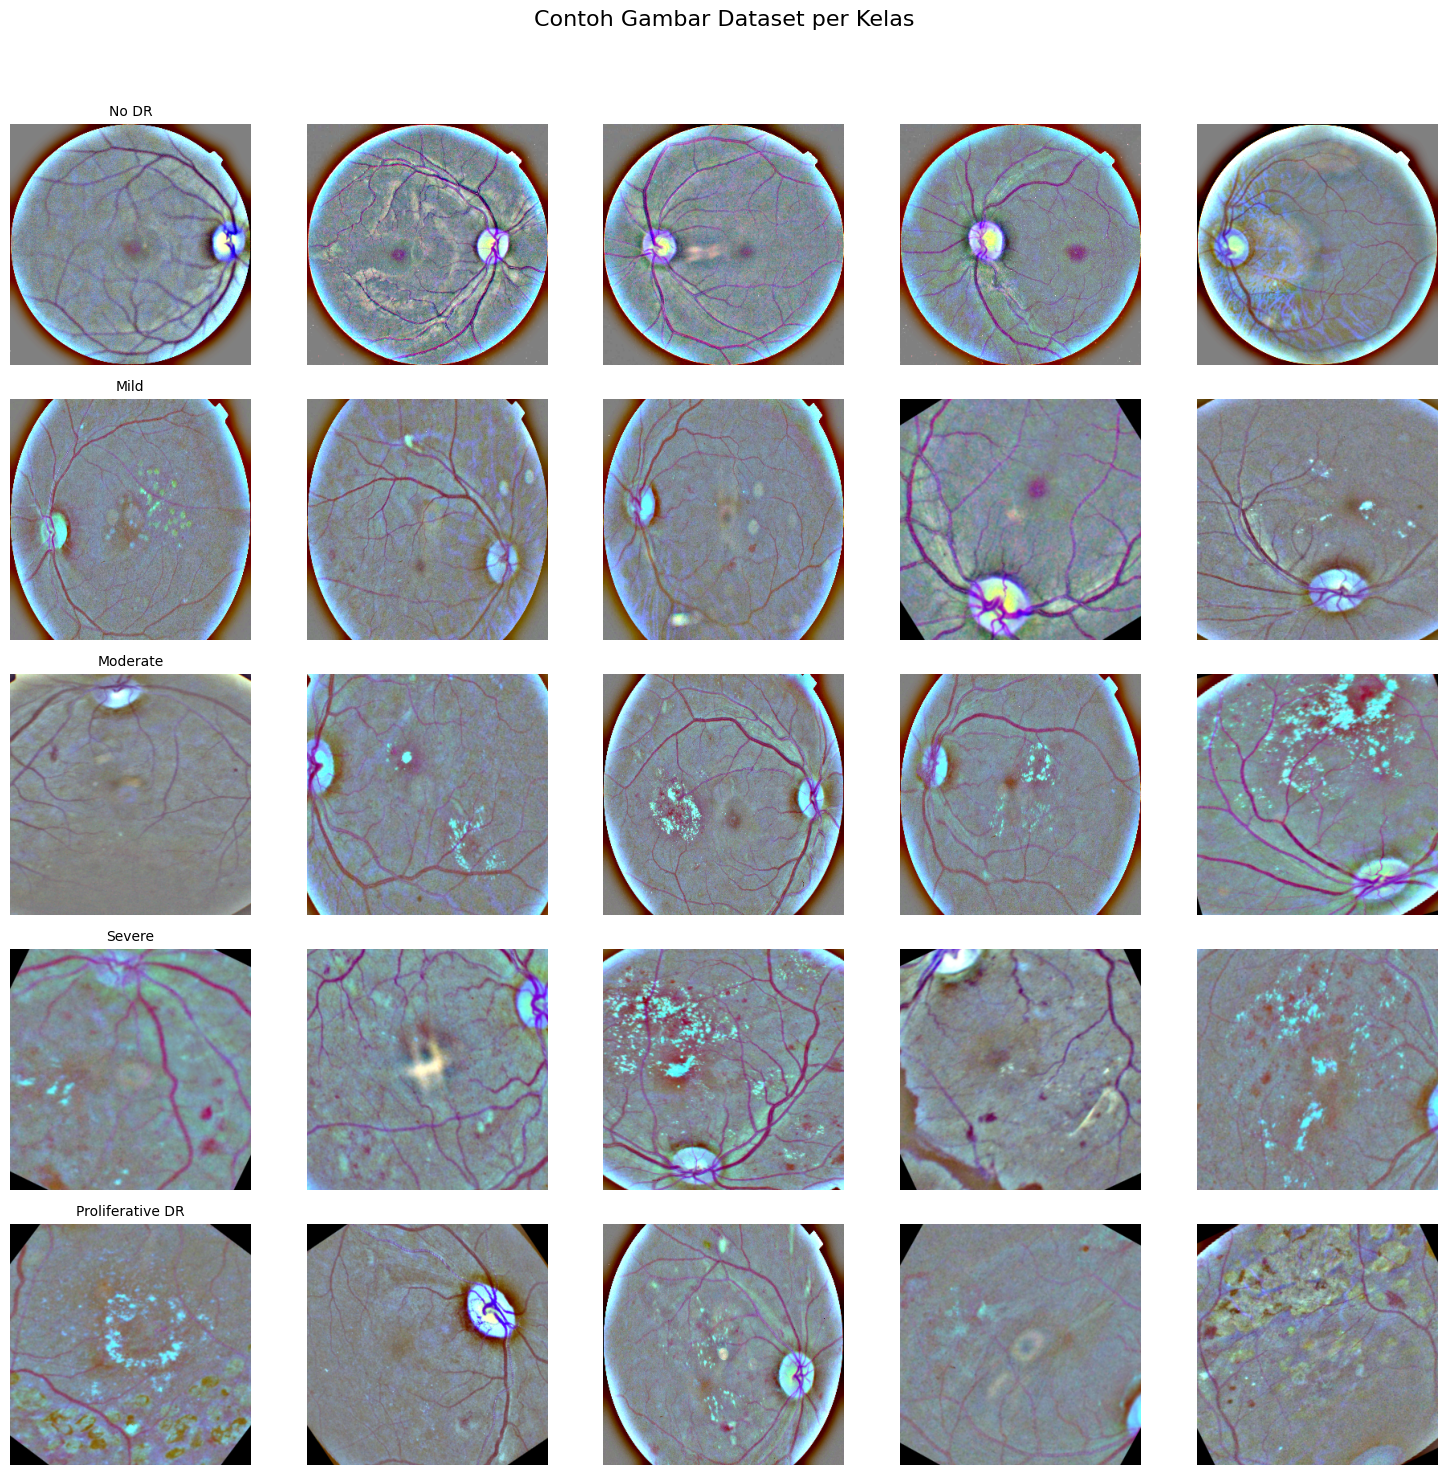

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Path ke dataset
dataset_path = '/content/drive/MyDrive/AptosData/aptos-augmented-images'

# Daftar nama kelas
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# Jumlah gambar yang ingin ditampilkan per kelas
num_samples_per_class = 5

def show_images_per_class(dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(num_samples * 3, len(class_names) * 3))

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, str(class_idx))
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Acak dan ambil beberapa file gambar
        selected_files = random.sample(image_files, min(num_samples, len(image_files)))

        for i, file_name in enumerate(selected_files):
            img_path = os.path.join(class_dir, file_name)
            img = Image.open(img_path).convert("RGB")

            plt_idx = class_idx * num_samples + i + 1
            plt.subplot(len(class_names), num_samples, plt_idx)
            plt.imshow(img)
            plt.axis('off')

            if i == 0:
                plt.title(class_name, fontsize=10)

    plt.suptitle("Contoh Gambar Dataset per Kelas", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Panggil fungsi untuk menampilkan gambar
show_images_per_class(dataset_path, class_names, num_samples=num_samples_per_class)
